In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla P100-PCIE-16GB


In [2]:
!pip install torch-summary
!pip install torchmetrics

In [3]:
import torch

torch.cuda.empty_cache()

In [4]:
import numpy as np

print(np.__version__)

2.0.2


In [ ]:
import random

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import os

from tqdm.notebook import tqdm

import cv2 as op

import torch

from torchsummary import summary

import torchmetrics

def set_seed(seed=42):
    torch.manual_seed(seed)

    torch.cuda.manual_seed(seed)

    np.random.seed(seed)

    random.seed(seed)

    torch.backends.cudnn.deterministic = True

    torch.backends.cudnn.benchmark = False


set_seed(42)
sns.set_theme()

print(np.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

2.0.2


'cuda'

In [ ]:
PATH ="/kaggle/input/eye-diseases-classification/dataset"
label2id = {}
for i, label in enumerate(os.listdir(PATH)):
    label2id[label] = i
    
id2label = {key : value for (value, key) in label2id.items()}

filenames, outcome = [], []

for label in tqdm(os.listdir(PATH)):
    for img in os.listdir(os.path.join(PATH, label)):
        filenames.append(os.path.join(PATH, label, img))
        outcome.append(label2id[label])

        
df = pd.DataFrame({
    "filename" : filenames,
    "outcome" : outcome
})

df = df.sample(frac = 1)   
df.head()

  0%|          | 0/4 [00:00<?, ?it/s]

,filename,outcome
463,/kaggle/input/eye-diseases-classification/data...,0
2426,/kaggle/input/eye-diseases-classification/data...,2
2661,/kaggle/input/eye-diseases-classification/data...,2
1483,/kaggle/input/eye-diseases-classification/data...,1
2860,/kaggle/input/eye-diseases-classification/data...,2


In [7]:
import os
print(os.listdir(PATH))

['glaucoma', 'normal', 'diabetic_retinopathy', 'cataract']


/tmp/ipykernel_778/262914980.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'outcome', data = df, palette = 'Blues_d')


<Axes: xlabel='outcome', ylabel='count'>

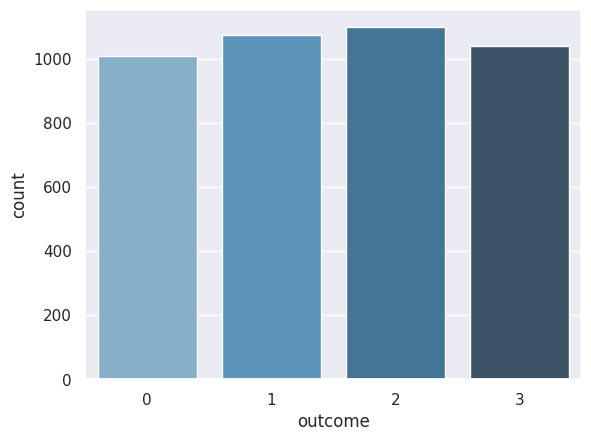

In [8]:
sns.countplot(x = 'outcome', data = df, palette = 'Blues_d')

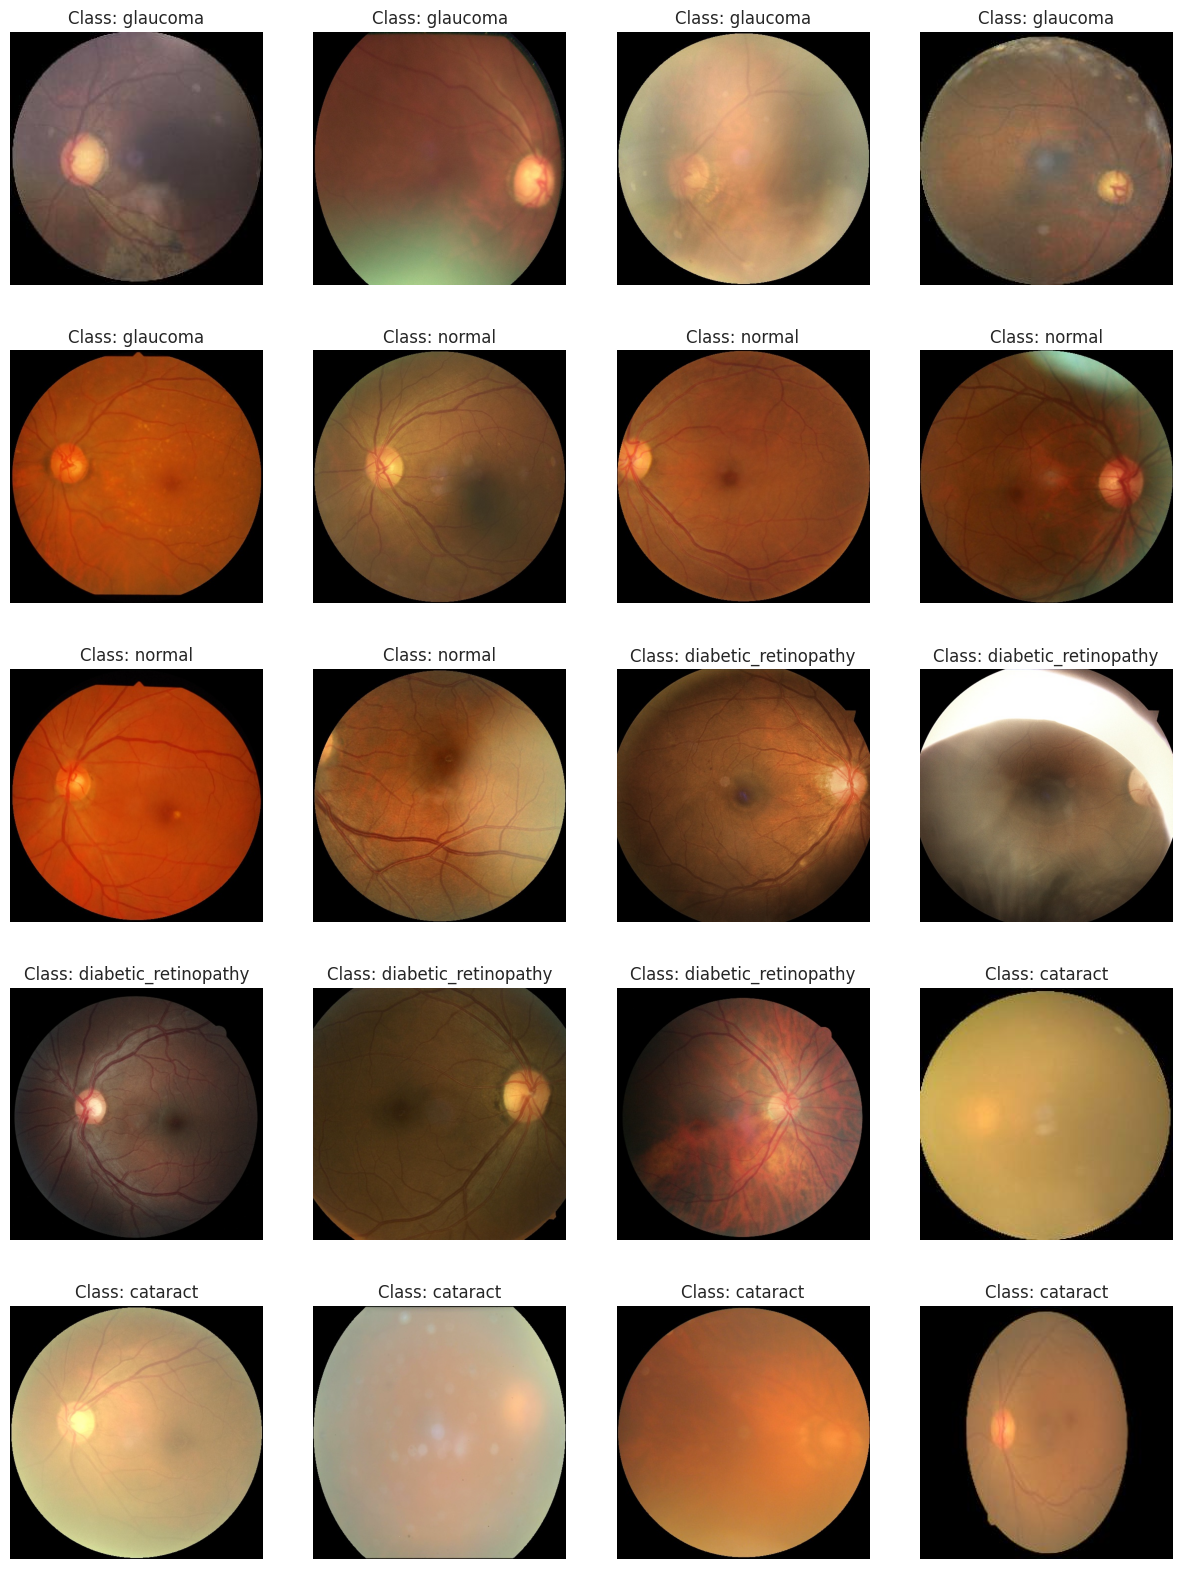

In [9]:
def load_image(path):
    img = plt.imread(path)
    img = (img - img.min())/img.max()
    return img

counter = 0

plt.figure(figsize = (15, 20))

for i in range(4):
    for path in df[df['outcome'] == i].sample(n = 5)['filename']:
        plt.subplot(5, 4, counter + 1)
        img = load_image(path)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Class:' + " " + id2label[i])
        counter += 1        
plt.show()

In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models

from torchvision.models import vit_b_16, ViT_B_16_Weights

import torch.nn.functional as f
from PIL import Image


train_transform = transforms.Compose([
     transforms.ToTensor(), 
     transforms.Resize((224, 224)),
     transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=1.0),   
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2), 
        
         
        
    ]),

        transforms.Normalize(mean=[0.485, 0.456, 0.406],          
                         std=[0.229, 0.224, 0.225]),
   
     
])




val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    
         
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    
])


class EyeDataset(Dataset):
    def __init__(self, df, n_classes, transform = None):
        self.df = df
        self.n_samples = len(self.df)
        self.n_classes = n_classes
        self.transform = transform
         

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        img_path = self.df.iloc[index, 0]
        img = plt.imread(img_path)
        label = self.df.iloc[index, 1]

        img = Image.open(img_path).convert("RGB")   

      

        if self.transform:
            img = self.transform(img)

        return img.float(), label



In [ ]:

from sklearn.model_selection import train_test_split


df_train, df_temp = train_test_split(
    df,
    test_size=0.30,
    stratify=df["outcome"],
    random_state=28
)


df_val, df_test = train_test_split(
    df_temp,
    test_size=1/3,
    stratify=df_temp["outcome"],
    random_state=28
)

df_train.shape, df_val.shape , df_test.shape

((2951, 2), (844, 2), (422, 2))

In [12]:
NUM_CLASSES = 4
BATCH_SIZE = 16

train_dataset = EyeDataset(df_train, NUM_CLASSES, train_transform)
val_dataset = EyeDataset(df_val, NUM_CLASSES, val_transform)
test_dataset = EyeDataset(df_test, NUM_CLASSES, val_transform)


train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [13]:
a, b = next(iter(train_loader))

print(a.shape, b.shape)
del(a)
del(b)

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [14]:
from collections import Counter
counts = Counter(df['outcome'])
print(counts)

Counter({2: 1098, 1: 1074, 3: 1038, 0: 1007})


In [ ]:
# =============================
# IMPORTS
# =============================
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
import torchmetrics
from torchvision.models import vit_b_16, ViT_B_16_Weights

# =============================
# MODEL
# =============================
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        weights = ViT_B_16_Weights.IMAGENET1K_V1
        self.base = vit_b_16(weights=weights)
        in_features = self.base.heads.head.in_features
        self.base.heads.head = nn.Linear(in_features, 4)
    def get_optimizer(self):
        return torch.optim.AdamW(
            self.parameters(),
            lr=1e-4,

            
            weight_decay=0.05
        )

    def forward(self, x):
        return self.base(x)
# =============================
# TRAINER
# =============================
class Trainer(nn.Module):
    def __init__(self, train_loader, val_loader, device):
        super().__init__()
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.model = Net().to(self.device)
        self.optimizer = self.model.get_optimizer()
        from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
        self.scheduler = CosineAnnealingWarmRestarts(
            self.optimizer,
            T_0=5,
            T_mult=2
        )

        self.loss_fxn = nn.CrossEntropyLoss(label_smoothing=0.1)

        self.accuracy = torchmetrics.Accuracy(
            task="multiclass",
            num_classes=NUM_CLASSES
        ).to(self.device)

        self.history = {
            "train_loss": [],
            "val_loss": [],
            "train_acc": [],
            "val_acc": []
        }

        self.current_epoch = 0

    # -------------------------
    # MIXUP
    # -------------------------
    def mixup_data(self, x, y, alpha=0.2):
        lam = np.random.beta(alpha, alpha)
        batch_size = x.size(0)
        index = torch.randperm(batch_size).to(self.device)

        mixed_x = lam * x + (1 - lam) * x[index]
        y_a, y_b = y, y[index]
        return mixed_x, y_a, y_b, lam

    # -------------------------
    # TRAIN STEP
    # -------------------------
    def training_step(self, x, y):
        if self.current_epoch > 3:
            x, y_a, y_b, lam = self.mixup_data(x, y)
            preds = self.model(x)
            loss = lam * self.loss_fxn(preds, y_a) + \
                   (1 - lam) * self.loss_fxn(preds, y_b)
        else:
            preds = self.model(x)
            loss = self.loss_fxn(preds, y)

        acc = self.accuracy(preds, y)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss, acc

    # -------------------------
    # VALIDATION STEP
    # -------------------------
    def val_step(self, x, y):
        with torch.no_grad():
            preds = self.model(x)
            loss = self.loss_fxn(preds, y)
            acc = self.accuracy(preds, y)
        return loss, acc

    # -------------------------
    # LOOP HELPER
    # -------------------------
    def step_fxn(self, loader, step):
        total_loss, total_acc = 0, 0

        for X, y in tqdm(loader, leave=False):
            X, y = X.to(self.device), y.to(self.device)
            loss, acc = step(X, y)
            total_loss += loss.item()
            total_acc += acc.item()

        return total_loss / len(loader), total_acc / len(loader)

    # -------------------------
    # TRAIN LOOP
    # -------------------------
    def train(self, epochs):
        best_val_acc = 0
        patience = 8
        patience_counter = 0

        for epoch in tqdm(range(epochs)):
            self.current_epoch = epoch

           

            train_loss, train_acc = self.step_fxn(
                self.train_loader, self.training_step
            )
            val_loss, val_acc = self.step_fxn(
                self.val_loader, self.val_step
            )

            self.scheduler.step(epoch)

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_loss)
            self.history["train_acc"].append(train_acc)
            self.history["val_acc"].append(val_acc)

            print(
                f"[Epoch {epoch+1}] "
                f"Train Loss: {train_loss:.3f}, Acc: {train_acc:.3f} | "
                f"Val Loss: {val_loss:.3f}, Acc: {val_acc:.3f}"
            )

           
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save(self.model.state_dict(), "best_model.pth")
                print("✨ Best model saved")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(
                        f"🛑 Early stopping at epoch {epoch+1}. "
                        f"Best val acc: {best_val_acc:.3f}"
                    )
                    break


In [19]:
import torchvision
print(torchvision.__version__)

0.23.0+cu126


In [20]:
trainer = Trainer(train_loader, val_loader, device)

In [22]:
summary(trainer.model.base, (3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         590,592
├─Encoder: 1-2                                [-1, 197, 768]            --
|    └─Dropout: 2-1                           [-1, 197, 768]            --
|    └─Sequential: 2-2                        [-1, 197, 768]            --
|    |    └─EncoderBlock: 3-1                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-2                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-3                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-4                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-5                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-6                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-7                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-8            

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         590,592
├─Encoder: 1-2                                [-1, 197, 768]            --
|    └─Dropout: 2-1                           [-1, 197, 768]            --
|    └─Sequential: 2-2                        [-1, 197, 768]            --
|    |    └─EncoderBlock: 3-1                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-2                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-3                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-4                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-5                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-6                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-7                 [-1, 197, 768]            7,087,872
|    |    └─EncoderBlock: 3-8            

In [23]:
total = len(df)

print(f"Train: {len(df_train)/total:.2f}")
print(f"Val  : {len(df_val)/total:.2f}")
print(f"Test : {len(df_test)/total:.2f}")


Train: 0.70
Val  : 0.20
Test : 0.10


In [24]:
trainer.train(epochs = 40)

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 1] Train Loss: 0.746, Acc: 0.787 | Val Loss: 0.616, Acc: 0.866
✨ Best model saved


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 2] Train Loss: 0.577, Acc: 0.887 | Val Loss: 0.558, Acc: 0.890
✨ Best model saved


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 3] Train Loss: 0.526, Acc: 0.909 | Val Loss: 0.533, Acc: 0.901
✨ Best model saved


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 4] Train Loss: 0.478, Acc: 0.934 | Val Loss: 0.528, Acc: 0.898


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 5] Train Loss: 0.579, Acc: 0.667 | Val Loss: 0.476, Acc: 0.936
✨ Best model saved


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 6] Train Loss: 0.577, Acc: 0.627 | Val Loss: 0.473, Acc: 0.933


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 7] Train Loss: 0.682, Acc: 0.582 | Val Loss: 0.590, Acc: 0.875


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 9] Train Loss: 0.614, Acc: 0.604 | Val Loss: 0.512, Acc: 0.918


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 10] Train Loss: 0.585, Acc: 0.612 | Val Loss: 0.510, Acc: 0.922


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 11] Train Loss: 0.589, Acc: 0.640 | Val Loss: 0.468, Acc: 0.941
✨ Best model saved


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 12] Train Loss: 0.544, Acc: 0.644 | Val Loss: 0.479, Acc: 0.929


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 13] Train Loss: 0.575, Acc: 0.668 | Val Loss: 0.489, Acc: 0.935


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 14] Train Loss: 0.512, Acc: 0.599 | Val Loss: 0.470, Acc: 0.941


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 15] Train Loss: 0.526, Acc: 0.659 | Val Loss: 0.480, Acc: 0.936


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 16] Train Loss: 0.532, Acc: 0.651 | Val Loss: 0.471, Acc: 0.939


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 17] Train Loss: 0.648, Acc: 0.622 | Val Loss: 0.543, Acc: 0.899


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 18] Train Loss: 0.634, Acc: 0.640 | Val Loss: 0.493, Acc: 0.932


  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/53 [00:00<?, ?it/s]

[Epoch 19] Train Loss: 0.606, Acc: 0.641 | Val Loss: 0.541, Acc: 0.909
🛑 Early stopping at epoch 19. Best val acc: 0.941


In [25]:
trainer.model.load_state_dict(torch.load("best_model.pth"))
trainer.model.eval()

Net(
  (base): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((7

In [26]:
test_preds, test_true = [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        preds = torch.argmax(trainer.model(x), dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_true.extend(y.cpu().numpy())


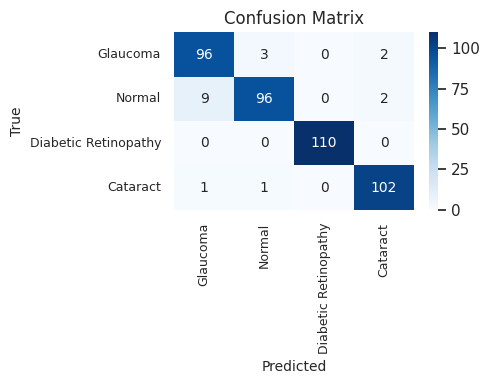

In [ ]:
plt.figure(figsize=(5, 4))   

sns.heatmap(
    cm_test,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    annot_kws={"size": 10}   

plt.title("Confusion Matrix", fontsize=12)
plt.xlabel("Predicted", fontsize=10)
plt.ylabel("True", fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(
    test_true,
    test_preds,
    target_names=class_names
))

                      precision    recall  f1-score   support

            Glaucoma       0.91      0.95      0.93       101
              Normal       0.96      0.90      0.93       107
Diabetic Retinopathy       1.00      1.00      1.00       110
            Cataract       0.96      0.98      0.97       104

            accuracy                           0.96       422
           macro avg       0.96      0.96      0.96       422
        weighted avg       0.96      0.96      0.96       422



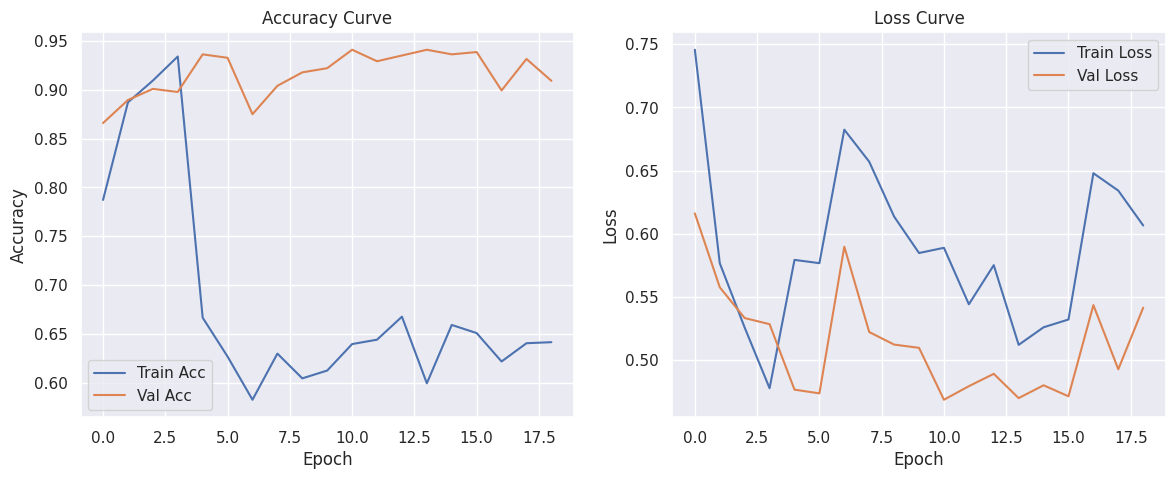

In [ ]:

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(trainer.history['train_acc'], label='Train Acc')
plt.plot(trainer.history['val_acc'], label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(trainer.history['train_loss'], label='Train Loss')
plt.plot(trainer.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [33]:
preds, true = [], []

with torch.no_grad():
    for x, y in tqdm(val_loader):
        pred = torch.argmax(trainer.model(x.to(device)), axis = 1).detach().cpu().numpy()
        preds.extend(pred)
        true.extend(y)
        
len(preds), len(true)

  0%|          | 0/53 [00:00<?, ?it/s]

(844, 844)

In [34]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

NUM_CLASSES = 4

all_probs = []
all_labels = []

trainer.model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        logits = trainer.model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()

        all_probs.append(probs)
        all_labels.extend(y.numpy())

all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)

y_onehot = label_binarize(all_labels, classes=[0,1,2,3])



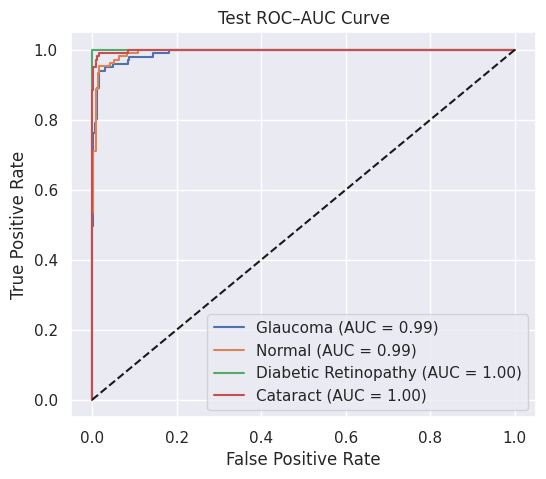

In [35]:
plt.figure(figsize=(6,5))

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_onehot[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test ROC–AUC Curve")
plt.legend()
plt.show()


In [37]:
import os
os.listdir("/kaggle/working")


['.virtual_documents', 'best_model.pth']

In [ ]:

torch.save(trainer.model, "best_model.pth")
print("Full model saved!")

Full model saved!


In [39]:
!pip install grad-cam


In [40]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [41]:
def apply_circular_mask(img):
    h, w, _ = img.shape
    center = (w // 2, h // 2)
    radius = min(center[0], center[1])

    Y, X = np.ogrid[:h, :w]
    dist = (X - center[0])**2 + (Y - center[1])**2
    mask = dist <= radius**2

    masked = img.copy()
    masked[~mask] = 0
    return masked

In [ ]:
import torch.serialization


torch.serialization.add_safe_globals([Net])

model = torch.load(
    "/kaggle/working/best_model.pth",
    map_location=device,
    weights_only=False   

model.eval()


Net(
  (base): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): LayerNorm((7

In [ ]:
CLASS_ID = 1 
row = df_test[df_test["outcome"] == CLASS_ID].iloc[8]
true_class = id2label[row["outcome"]]
img_path = row["filename"]

print("True class:", id2label[row["outcome"]])
print("Image path:", img_path)


True class: normal
Image path: /kaggle/input/eye-diseases-classification/dataset/normal/1034_left.jpg


In [68]:
img = Image.open(img_path).convert("RGB")

input_tensor = val_transform(img).unsqueeze(0).to(device)

rgb_img = np.array(img.resize((224, 224))) / 255.0
rgb_img = apply_circular_mask(rgb_img)


In [69]:
with torch.no_grad():
    outputs = model(input_tensor)
    pred_class = torch.argmax(outputs).item()

print("Model prediction:", id2label[pred_class])


Model prediction: normal


In [ ]:
def reshape_transform(tensor, height=14, width=14):
    tensor = tensor[:, 1:, :]            
    tensor = tensor.reshape(
        tensor.size(0),
        height,
        width,
        tensor.size(2)
    )
    tensor = tensor.permute(0, 3, 1, 2)  
    return tensor


In [71]:
cam = GradCAM(
    model=model,
    target_layers=[model.base.encoder.layers[-1].ln_1],
    reshape_transform=reshape_transform
)


In [72]:
targets = [ClassifierOutputTarget(pred_class)]

In [73]:
grayscale_cam = cam(
    input_tensor=input_tensor,
    targets=targets
)[0]

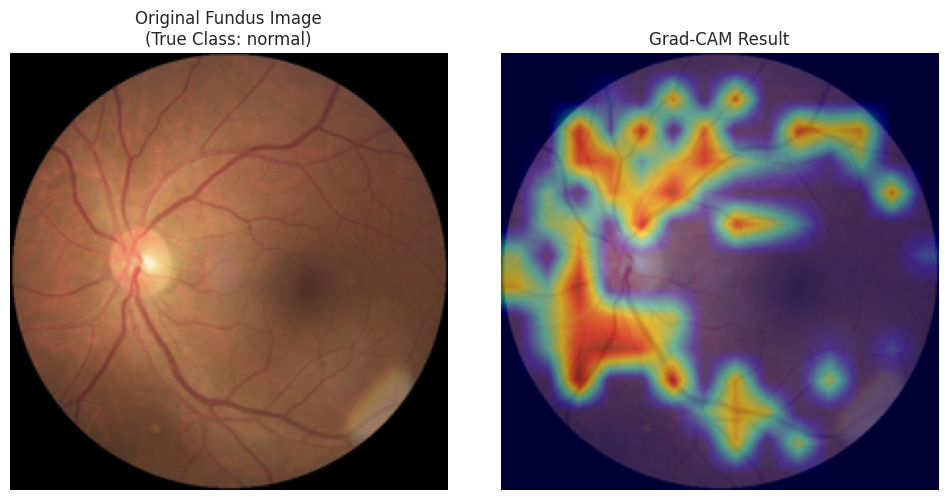

In [ ]:
visualization = show_cam_on_image(
    rgb_img,
    grayscale_cam,
    use_rgb=True,
    image_weight=0.6
)


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(rgb_img)
plt.title(f"Original Fundus Image\n(True Class: {true_class})")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM Result") 

plt.axis("off")

plt.tight_layout()
plt.show()